In [246]:
import sys
sys.path.insert(0, r'../..')

In [247]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import imageio
import pickle
import os
from tqdm import tqdm_notebook as tqdm

In [248]:
from lib.video import *

In [249]:
UI_DATA_DIR = '../../output/features/ui_probs/'
UI_REAL = '../../data/test/real_start_test.csv'
UI_PREDICTION = '../../output/features/games_starts_test.csv'
FRAME_RATE = 4

In [250]:
pd.read_csv(UI_PREDICTION)

,Unnamed: 0,file_name,first_start,second_start
0,0,resized_645001_5.mp4,0,3992
1,1,resized_645066_5.mp4,0,2700
2,2,resized_645098_5.mp4,3268,6148
3,3,resized_645195_5.mp4,504,3808
4,4,resized_645286_5.mp4,396,4100
5,5,resized_645310_5.mp4,0,4536
6,6,resized_646186_5.mp4,656,3864
7,7,resized_648559_5.mp4,1320,4044


In [251]:
real_ui = pd.read_csv(UI_REAL)

In [252]:
real_ui

,Unnamed: 0,file_name,first_start,second_start
0,0,resized_645001_5.mp4,360,4110
1,1,resized_645066_5.mp4,1020,4800
2,2,resized_645098_5.mp4,2160,6060
3,3,resized_645195_5.mp4,210,3990
4,4,resized_645286_5.mp4,330,3990
5,5,resized_645310_5.mp4,900,4740
6,6,resized_646186_5.mp4,480,4320
7,7,resized_648559_5.mp4,270,3960


In [253]:
def ui_csv_to_dict(table):
    result = {}
    for _, v in table.iterrows():
        name = v.file_name
        result[name] = v.first_start, v.second_start
    return result

In [254]:
ui_csv_to_dict(real_ui)

{'resized_645001_5.mp4': (360, 4110),
 'resized_645066_5.mp4': (1020, 4800),
 'resized_645098_5.mp4': (2160, 6060),
 'resized_645195_5.mp4': (210, 3990),
 'resized_645286_5.mp4': (330, 3990),
 'resized_645310_5.mp4': (900, 4740),
 'resized_646186_5.mp4': (480, 4320),
 'resized_648559_5.mp4': (270, 3960)}

In [255]:
def read_all_ui():
    data = {}
    for file in os.listdir(UI_DATA_DIR):
        if not file.endswith('.pickle'):
            continue
        path = UI_DATA_DIR + file
        with open(path, 'rb') as f:
            data[file] = pickle.load(f)
    return data

In [256]:
ui_data = read_all_ui()

In [257]:
def ui_filter(ui_prob):
    t = len(ui_prob) * FRAME_RATE
    percent = 100 * (90 * 60 / t)
    print(percent)
    l = np.percentile(ui_prob, percent + 15)
    r = np.percentile(ui_prob, percent - 15)
    print(l, r)
    data = np.array(ui_prob)
    data[data > r] = 1
    data[data < l] = -1
    data[np.abs(data) < 1] = 0
    win = 20
    for i in range(win, len(data) - win):
        if data[i] != 0:
            continue
        a = 0
        for j in np.arange(-win, win):
            a += data[i + j]
        if np.abs(a) > win // 2:
            data[i] = np.sign(a)
    return data

In [258]:
def find_two_segments(probs):
    l = 45 * 60 // FRAME_RATE  # 45min in frames
    n = len(probs)
    pref = np.cumsum(np.array(probs) > 0)
    mx = -np.inf
    best_l1, best_l2 = 0, 0
    
    m = 2 * 60 // FRAME_RATE 
    
    def seg_sum(l, r):
        return pref[r] - pref[l]
    
    for l1 in range(n - l):
        for l2 in range(l1 + l + 900 // FRAME_RATE, min(n - l, l1 + l + 1250 // FRAME_RATE)):
            s1, s2 = seg_sum(l1, l1 + l), seg_sum(l2, l2 + l)
            d1, d2 = seg_sum(l1, l1 + m), seg_sum(l2, l2 + m)
            f = s1 + s2 + d1 * 2 + d2 * 2
            if mx < f:
                mx = f
                best_l1, best_l2 = l1, l2
    return best_l1 * FRAME_RATE, best_l2 * FRAME_RATE

In [259]:
def remove_suf(name):
    return name.rsplit('.', 1)[0]

In [260]:
def create_graph(start, n):
    l = 45 * 60 // FRAME_RATE 
    a = np.ones(n) * -1.1
    a[start[0]//FRAME_RATE:start[0]//FRAME_RATE+l] = 1.2
    a[start[1]//FRAME_RATE:start[1]//FRAME_RATE+l] = 1.2
    return a

resized_645001_5.mp4.pickle
75.80011229646266
0.926516832463 0.757051865332
(244, 3992)
(360, 4110)
Diff 1: -116
Diff 2: -118


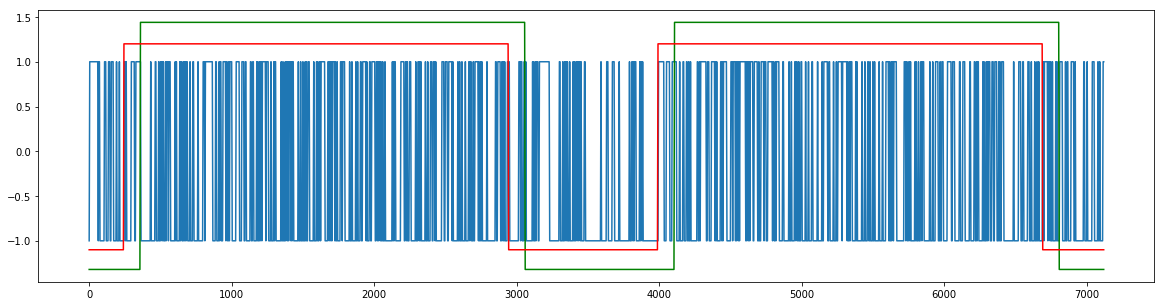

resized_645286_5.mp4.pickle
72.5416442772703
0.928278688525 0.872950819672
(228, 4108)
(330, 3990)
Diff 1: -102
Diff 2: 118


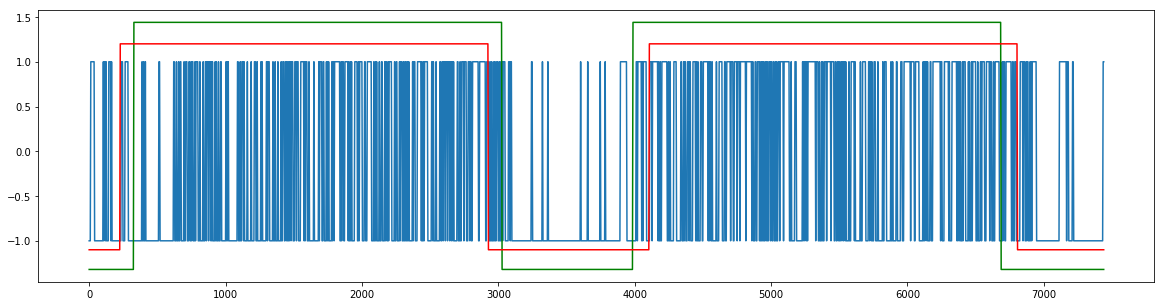

resized_645195_5.mp4.pickle
76.3143018654607
0.975856697819 0.855140186916
(132, 3824)
(210, 3990)
Diff 1: -78
Diff 2: -166


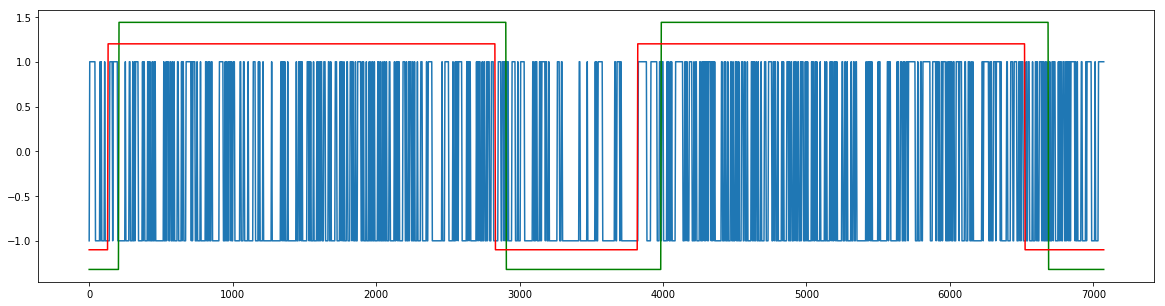

resized_645310_5.mp4.pickle
70.16632016632016
0.938396462167 0.780148019155
(0, 3908)
(900, 4740)
Diff 1: -900
Diff 2: -832


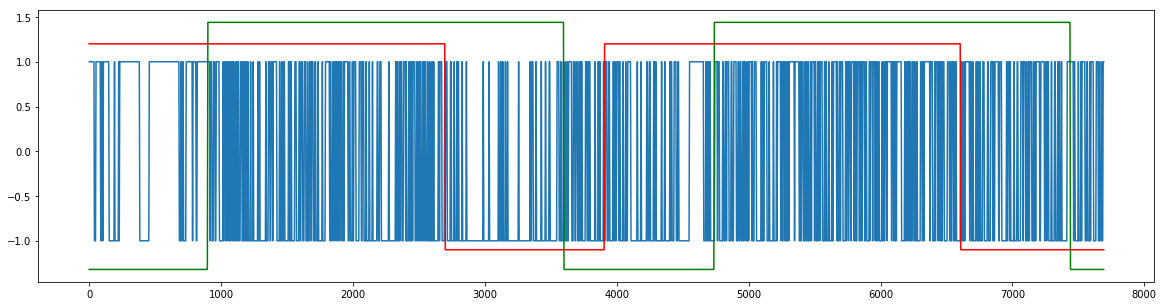

resized_645066_5.mp4.pickle
68.01007556675063
0.896466212027 0.592684438934
(304, 4144)
(1020, 4800)
Diff 1: -716
Diff 2: -656


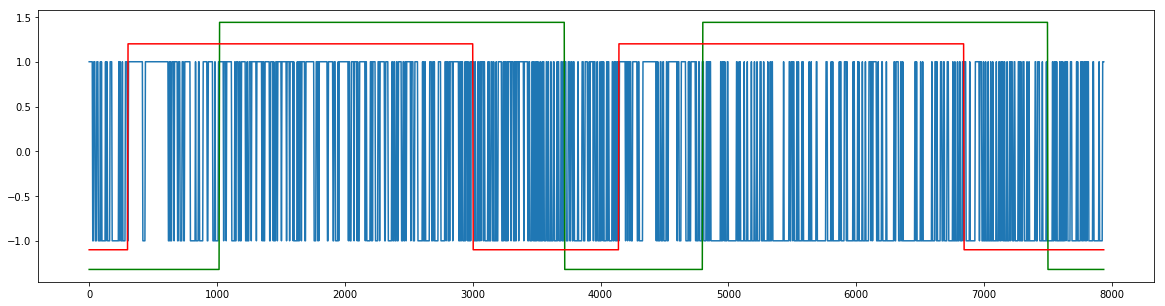

resized_648559_5.mp4.pickle
77.01083856246434
0.939569062131 0.793707360648
(0, 3816)
(270, 3960)
Diff 1: -270
Diff 2: -144


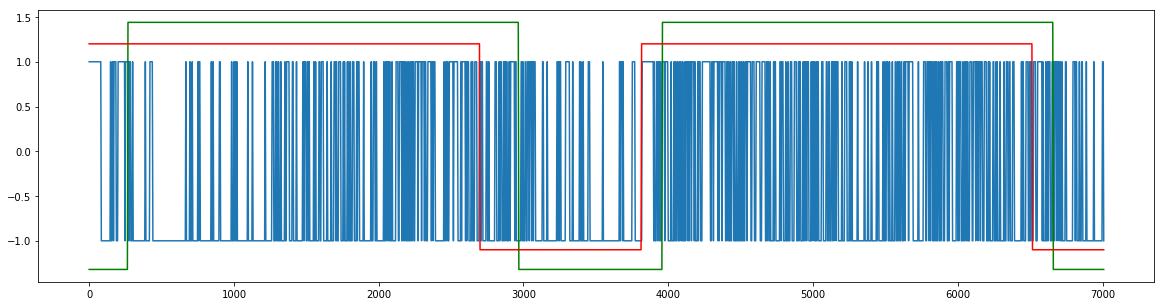

resized_646186_5.mp4.pickle
73.60959651035986
0.960929250264 0.84705063571
(328, 4064)
(480, 4320)
Diff 1: -152
Diff 2: -256


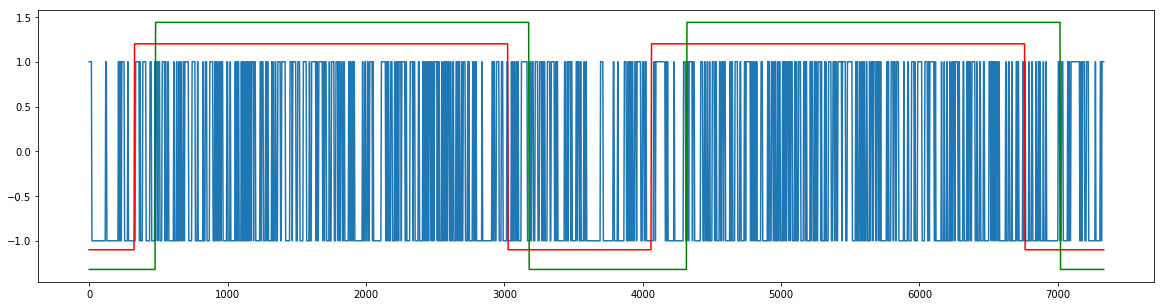

resized_645098_5.mp4.pickle
53.423031262366436
0.916983179598 0.708391627611
(3300, 7056)
(2160, 6060)
Diff 1: 1140
Diff 2: 996


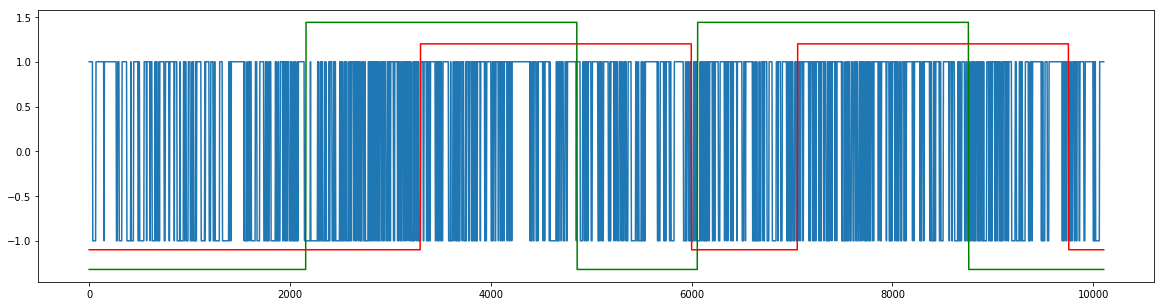

In [261]:
for file, ui_prob in ui_data.items():
    print(file)
    fig, ax = plt.subplots(figsize=(20, 5))
    data = ui_filter(ui_prob)
    
    predict_starts = find_two_segments(data)
    
    print(predict_starts)
    real_starts = ui_csv_to_dict(real_ui)[remove_suf(file)]
    print(real_starts)
    print('Diff 1:', predict_starts[0] - real_starts[0])
    print('Diff 2:', predict_starts[1] - real_starts[1])
    
    ax.plot(np.arange(len(data))*FRAME_RATE, data)
    ax.plot(np.arange(len(data)) * FRAME_RATE, create_graph(real_starts, len(data))*1.2, color='green')
    ax.plot(np.arange(len(data)) * FRAME_RATE, create_graph(predict_starts, len(data)), color='red')
    plt.show()